In [136]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as pyplot
%matplotlib inline

In [137]:
df = pd.read_csv('CreditScoring.csv')

In [138]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [139]:
status_values ={
    1:'ok',
    2:'default',
    0:'unknown'
}
df.status = df.status.map(status_values)

In [140]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [141]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [142]:
for c in ['income','expenses','assets','debt']:
    df[c] = df[c].replace(to_replace=99999999,value=np.nan)

In [143]:
df = df[df.status!='unknown'].reset_index(drop=True)
df.status.value_counts()

status
ok         3200
default    1254
Name: count, dtype: int64

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=11)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=11)


In [145]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [146]:
df_train.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,default,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,default,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,ok,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,default,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,ok,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


In [147]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status=='default').astype('int').values

In [148]:
del df_train['status']
del df_val['status']
del df_test['status']

Decision Trees

In [149]:
df_train.iloc[0].to_dict()

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [150]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer


In [151]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [152]:
dv = DictVectorizer(sparse=False)
X_train=dv.fit_transform(train_dicts)

In [153]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [154]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [155]:
y_pred = dt.predict_proba(X_val)[:,1]

In [156]:
roc_auc_score(y_val,y_pred)

np.float64(0.7389079944782155)

In [157]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_pred)

np.float64(0.7761016984958594)

In [158]:
from sklearn.tree import export_text 

In [159]:
print(export_text(dt,feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



In [160]:
for d in [1,2,3,4,5,6,10,15,20,None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train,y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)

    print('%4s -> %.3f'%(d,auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.761
  10 -> 0.690
  15 -> 0.679
  20 -> 0.667
None -> 0.652


In [161]:
scores = []

for d in [4,5,6]:
    for s in [1,2,5,10,15,20,100,200,500]:
        dt = DecisionTreeClassifier(max_depth=d,min_samples_leaf=s)
        dt.fit(X_train,y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)

        print('(%s,%3d) -> %.3f'%(d,s,auc))
        scores.append((d,s,auc))
        

(4,  1) -> 0.761
(4,  2) -> 0.761
(4,  5) -> 0.761
(4, 10) -> 0.761
(4, 15) -> 0.764
(4, 20) -> 0.761
(4,100) -> 0.756
(4,200) -> 0.747
(4,500) -> 0.680
(5,  1) -> 0.766
(5,  2) -> 0.766
(5,  5) -> 0.768
(5, 10) -> 0.762
(5, 15) -> 0.772
(5, 20) -> 0.774
(5,100) -> 0.763
(5,200) -> 0.759
(5,500) -> 0.680
(6,  1) -> 0.757
(6,  2) -> 0.755
(6,  5) -> 0.761
(6, 10) -> 0.778
(6, 15) -> 0.785
(6, 20) -> 0.774
(6,100) -> 0.776
(6,200) -> 0.768
(6,500) -> 0.680


In [162]:
df_scores = pd.DataFrame(scores,columns=['max_depth','min_leaves_sample','auc'])
df_scores.sort_values(by='auc',ascending=False).head()

,max_depth,min_leaves_sample,auc
22,6,15,0.784856
21,6,10,0.777803
24,6,100,0.776434
14,5,20,0.774028
23,6,20,0.773634


In [163]:
df_scores_pivot = df_scores.pivot(index='min_leaves_sample',columns = ['max_depth'],
                values=['auc'])
df_scores_pivot

auc                    
max_depth                 4         5         6
min_leaves_sample                              
1                  0.761283  0.766496  0.756781
2                  0.761283  0.766496  0.755043
5                  0.761283  0.768173  0.761225
10                 0.761283  0.761809  0.777803
15                 0.763726  0.771806  0.784856
20                 0.760910  0.774028  0.773634
100                0.755937  0.763384  0.776434
200                0.747260  0.759073  0.768267
500                0.679842  0.679842  0.679842

<Axes: xlabel='None-max_depth', ylabel='min_leaves_sample'>

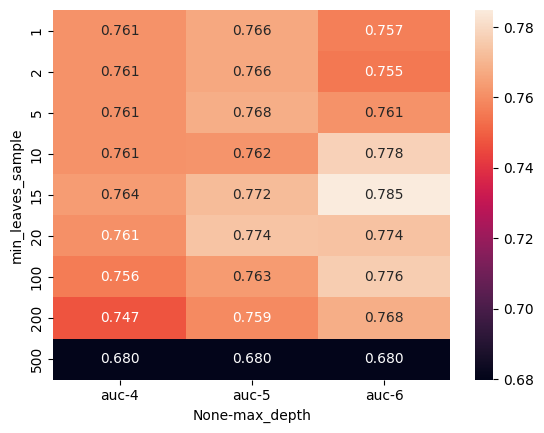

In [164]:
sns.heatmap(df_scores_pivot,annot=True,fmt='.3f')

In [165]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=15)
dt.fit(X_train,y_train)
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

np.float64(0.7850802838390931)

In [166]:
import xgboost as xgb

In [171]:

dtrain = xgb.DMatrix(X_train,
                label=y_train,
                feature_names=list(dv.get_feature_names_out()))
dval = xgb.DMatrix(X_val,
                label=y_val,
                feature_names=list(dv.get_feature_names_out()))

In [183]:
xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'seed':1,
    'verbosity':1,   
}

model = xgb.train(xgb_params,dtrain,num_boost_round=10)

In [181]:
y_pred = model.predict(dval)

In [182]:
roc_auc_score(y_val,y_pred)

np.float64(0.8065256351262986)